## Načtení knihoven

Budeme používat samozřejmě `pandas`, pro vizualizaci pak [`matplotlib`](https://matplotlib.org/) a [`seaborn`](https://seaborn.pydata.org/).

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
def extract_and_clean_chmi_excel_sheet(excel_data, sheet_name):
    """Parse ČHMÚ historical meteo excel data"""
    # načti list z excel souboru a převeď na tidy data formát
    data_tidy = (
        excel_data.parse(sheet_name, skiprows=3)
        .melt(id_vars=["rok", "měsíc"], var_name="den", value_name=sheet_name)
        .dropna()
    )
    # vytvoř časovou řadu datumů
    datum = pd.to_datetime(
        data_tidy[["rok", "měsíc", "den"]].rename(
            columns={"rok": "year", "měsíc": "month", "den": "day"}
        )
    )
    # přidej sloupec datum jako index a odstraň den, měsíc, rok a vrať setříděný výsledek
    return (
        data_tidy.assign(datum=datum)
        .set_index("datum")
        .drop(columns=["rok", "měsíc", "den"])
        .sort_index()
    )

In [5]:
# otevři Excel soubor
excel_data_ruzyne = pd.ExcelFile("P1PRUZ01.xls")
# načti všechny listy kromě prvního
extracted_sheets = (
    extract_and_clean_chmi_excel_sheet(excel_data_ruzyne, sheet_name)
    for sheet_name in excel_data_ruzyne.sheet_names[1:]
)
# spoj všechny listy do jednoho DataFrame
ruzyne_tidy = pd.concat(extracted_sheets, axis=1)

# Úkoly

Načtení dat z Lysé Hory

In [6]:
LYSA_DATA_FILENAME = "O1LYSA01.xls"

excel_data_lysa = pd.ExcelFile(LYSA_DATA_FILENAME)
extracted_sheets_lysa = (
    extract_and_clean_chmi_excel_sheet(excel_data_lysa,sheet_name)
    for sheet_name in excel_data_lysa.sheet_names[1:]
)

lysahora_tidy = pd.concat(extracted_sheets_lysa, axis=1)

0. Pomocí grafu porovnej vývoj ročního úhrnu srážek v jednotlivých stanicích.

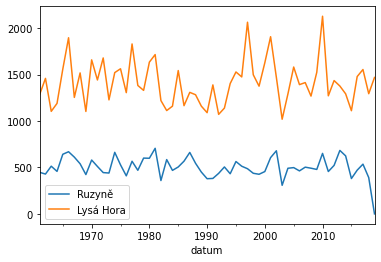

In [52]:
srazky = pd.DataFrame(
    {"Ruzyně": ruzyne_tidy["úhrn srážek"], "Lysá Hora": lysahora_tidy["úhrn srážek"]}
)
srazky.resample("1Y").sum().plot();

1. Zjisti, ve které z těchto stanic byl nejteplejší den v roce 2010 a který to byl.

In [11]:
# využijeme tidy data :)
meteodata_tidy = pd.concat((
    ruzyne_tidy.assign(stanice="Ruzyně"),
    lysahora_tidy.assign(stanice="Lysá Hora"),
# reset index není úplně nutný, ale časový index už by nebyl teď unikátní
# mohli bychom to řešit i multiindexem
)).reset_index()

In [12]:
meteodata_tidy_2010 = meteodata_tidy.loc[meteodata_tidy["datum"].dt.year == 2010]
meteodata_tidy_2010[["datum", "stanice", "teplota maximální"]].loc[
    meteodata_tidy_2010["teplota maximální"]
    == meteodata_tidy_2010["teplota maximální"].max()
]

,datum,stanice,teplota maximální
18093,2010-07-16,Ruzyně,34.6


2. Zjisti, kde bylo (v průměru) nejteplejších 90 % dní v roce 2018 a kde nejstudenějších 10 %.

In [13]:
# nejteplejší data vybereme pomocí 10 % kvantilu

nejteplejsi_90 = {
    "Ruzyně": ruzyne_tidy.loc[
        ruzyne_tidy["teplota průměrná"] > ruzyne_tidy["teplota průměrná"].quantile(0.1),
        "teplota průměrná",
    ].mean(),
    "Lysá Hora": lysahora_tidy.loc[
        lysahora_tidy["teplota průměrná"] > lysahora_tidy["teplota průměrná"].quantile(0.1),
        "teplota průměrná",
    ].mean(),
}
nejteplejsi_90

{'Ruzyně': 10.033592804922948, 'Lysá Hora': 4.678027368964628}

In [15]:
# nejstudenější data vybereme také pomocí 10 % kvantilu

nejstudenejsi_10 = {
    "Ruzyně": ruzyne_tidy.loc[
        ruzyne_tidy["teplota průměrná"] < ruzyne_tidy["teplota průměrná"].quantile(0.1),
        "teplota průměrná",
    ].mean(),
    "Lysá Hora": lysahora_tidy.loc[
        lysahora_tidy["teplota průměrná"] < lysahora_tidy["teplota průměrná"].quantile(0.1),
        "teplota průměrná",
    ].mean(),
}
nejstudenejsi_10

{'Ruzyně': -5.827113840340104, 'Lysá Hora': -10.48576112412178}

3. Porovnej průměrný denní svit v 90. letech (1990 - 1999) v Praze a na Lysé Hoře.

In [17]:
meteodata_tidy_90s = meteodata_tidy.loc[
    (meteodata_tidy["datum"].dt.year >= 1990)
    & (meteodata_tidy["datum"].dt.year <= 1990)
]

for stanice in meteodata_tidy["stanice"].unique():
    sunshine = meteodata_tidy_90s.loc[
        meteodata_tidy["stanice"] == stanice, "sluneční svit"
    ].mean()
    print(f"Průměný sluneční svit v {stanice}: {sunshine:.2f}")

Průměný sluneční svit v Ruzyně: 5.53
Průměný sluneční svit v Lysá Hora: 4.35


4. Načti data z https://data4pydata.s3-eu-west-1.amazonaws.com/pyladies/P1PRUZ01schibami.xls, kde jsou chybějící data označena jako `#CHYBA MĚŘENÍ`.

In [85]:
CHYBA_DATA_FILENAME = "P1PRUZ01schibami.xls"
excel_data_schibami = pd.ExcelFile(CHYBA_DATA_FILENAME)


def extract_and_clean_chmi_excel_sheet_schibami(excel_data, sheet_name):
    """Parse ČHMÚ historical meteo excel data"""
    # načti list z excel souboru a převeď na tidy data formát
    data_tidy = (
        # přidáme na_values a keep_default_na=True
        excel_data.parse(sheet_name, skiprows=3, na_values=["#CHYBA MĚŘENÍ"])  # , keep_default_na=True)
        .melt(id_vars=["rok", "měsíc"], var_name="den", value_name=sheet_name)
    )
    # vytvoř časovou řadu datumů
    datum = pd.to_datetime(
        data_tidy[["rok", "měsíc", "den"]].rename(
            columns={"rok": "year", "měsíc": "month", "den": "day"}
        ),
        # použijeme tentokrát errors=coerce místo dropna předtím, abychom měli NA i v datum sloupci
        # a mohli pak rozlišit kde byla chybějící hodnota a kde nesmyslné datum
        errors="coerce",
    )
    # přidej sloupec datum jako index a odstraň den, měsíc, rok a vrať setříděný výsledek
    return (
        data_tidy.assign(datum=datum)
        .dropna(subset=["datum"])
        .set_index("datum")
        .drop(columns=["rok", "měsíc", "den"])
        .sort_index()
        # fillna použijeme na všechny sloupce, ale až potom co jsme odstanili špatné datumy
        # a seřadili jsme podle datumů
        .fillna(method="ffill") 
    )

extracted_sheets_schibami = (
    extract_and_clean_chmi_excel_sheet_schibami(excel_data_schibami, sheet_name)
    for sheet_name in excel_data_schibami.sheet_names[1:]
)
data_schibami_tidy = pd.concat(extracted_sheets_schibami, axis=1)

In [89]:
# tady byly původně #CHYBY MĚŘENÍ
radky_schibami = pd.DatetimeIndex([
    pd.Timestamp("1962-09-07"),
    pd.Timestamp("1974-05-24"),
    pd.Timestamp("2006-04-16"),
    pd.Timestamp("2013-07-06"),
])
radky_schibami

DatetimeIndex(['1962-09-07', '1974-05-24', '2006-04-16', '2013-07-06'], dtype='datetime64[ns]', freq=None)

In [79]:
data_schibami_tidy.loc[radky_schibami]

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
1962-09-07,NaN,20.2,14.3,8.0,961.9,69.0,0.1,0.0,3.1
1974-05-24,10.1,14.5,5.1,2.3,963.7,74.0,NaN,0.0,2.1
2006-04-16,NaN,16.2,8.1,7.3,965.9,84.0,1.4,0.0,1.8
2013-07-06,18.9,23.6,14.4,NaN,985.8,78.0,0.0,0.0,3.5


In [86]:
data_schibami_tidy.loc[radky_schibami]

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
1962-09-07,17.4,20.2,14.3,8.0,961.9,69.0,0.1,0.0,3.1
1974-05-24,10.1,14.5,5.1,2.3,963.7,74.0,0.4,0.0,2.1
2006-04-16,9.1,16.2,8.1,7.3,965.9,84.0,1.4,0.0,1.8
2013-07-06,18.9,23.6,14.4,3.3,985.8,78.0,0.0,0.0,3.5


In [88]:
data_schibami_tidy.loc[radky_schibami - pd.Timedelta("1D")]

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
1962-09-06,17.4,19.2,12.3,7.3,963.8,82.0,0.2,0.0,0.0
1974-05-23,8.9,13.4,6.6,5.7,961.9,72.0,0.4,0.0,4.9
2006-04-15,9.1,13.9,1.3,3.3,972.4,71.0,0.6,0.0,9.1
2013-07-05,18.1,23.4,14.7,3.3,984.0,83.0,0.0,0.0,1.8


5. Jak často přijíždí Svatý Martin na bílém koni? Jaké je procento svátků Sv. Martina (11. 11.), kdy byla celková výška sněhu větší než 0?

In [184]:
(
    ruzyne_tidy.loc[
        (ruzyne_tidy.index.month == 11) & (ruzyne_tidy.index.day == 11),
        "celková výška sněhu",
    ]
    > 0
).value_counts(normalize=True)

False    0.931034
True     0.068966
Name: celková výška sněhu, dtype: float64

6. Který z ledových mužů je nejmrazivější? Pankrác (12. 5.), Servác (13. 5.) nebo Bonifác (14. 5.)? Zjisti to porovnáním procent těchto dní s minimální teplotou < 0. Pokud budou procenta vyrovnaná, vyhraje den s nižší průměrnou teplotou.

In [205]:
ledovi_muzi_data = {
    "Pankrác": ruzyne_tidy.loc[
        (ruzyne_tidy.index.month == 5) & (ruzyne_tidy.index.day == 12)
    ],
    "Servác": ruzyne_tidy.loc[
        (ruzyne_tidy.index.month == 5) & (ruzyne_tidy.index.day == 13)
    ],
    "Bonifác": ruzyne_tidy.loc[
        (ruzyne_tidy.index.month == 5) & (ruzyne_tidy.index.day == 14)
    ],
}

ledovi_muzi = {}
for jmeno in ledovi_muzi_data:
    ledovi_muzi[jmeno] = (
        ledovi_muzi_data[jmeno]["teplota minimální"] < 0
    ).sum() / ledovi_muzi_data[jmeno].shape[0]
    
pd.Series(ledovi_muzi).idxmax()

'Bonifác'